In [1]:
from kbmodpy import kbmod as kb
import numpy
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [7]:
files = os.listdir(path)

In [8]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [169]:
images = [kb.layered_image(f) for f in files]

In [170]:
p = kb.psf(1.0)

In [171]:
ix = 3000
iy = 3200
xv = 2300
yv = 800
flux = 1500
init_time = images[0].get_time()
for i in images:
    t = i.get_time()-init_time
    print('x: '+str(ix+xv*t) + ' y: ' + str(iy+yv*t) )
    i.add_object( ix+xv*t, iy+yv*t, flux, p )
    

x: 3000.0 y: 3200.0
x: 3196.7949000012595 y: 3268.450400000438
x: 3354.7439499969187 y: 3323.3891999989282
x: 3462.822329996561 y: 3360.981679998804


In [172]:
stack = kb.image_stack(images)

In [173]:
flags = ~0 # mask a pixel with any flag
flag_exceptions = [32,39]#int('100000', 2) # unless it also has this flag
master_flags = int('100111', 2) # mask any pixels which have any of 
# these more than two times

In [174]:
stack.apply_mask_flags(flags, flag_exceptions)

In [175]:
stack.apply_master_mask(master_flags, 2)

In [176]:
images = stack.get_images()

In [177]:
img = images[1] #kb.layered_image("test",4096, 4096, 20.0, 400.0, 0.0)#

In [178]:
sub = img.science()

In [179]:
sub = sub[ 2400:3900,2800:4000]

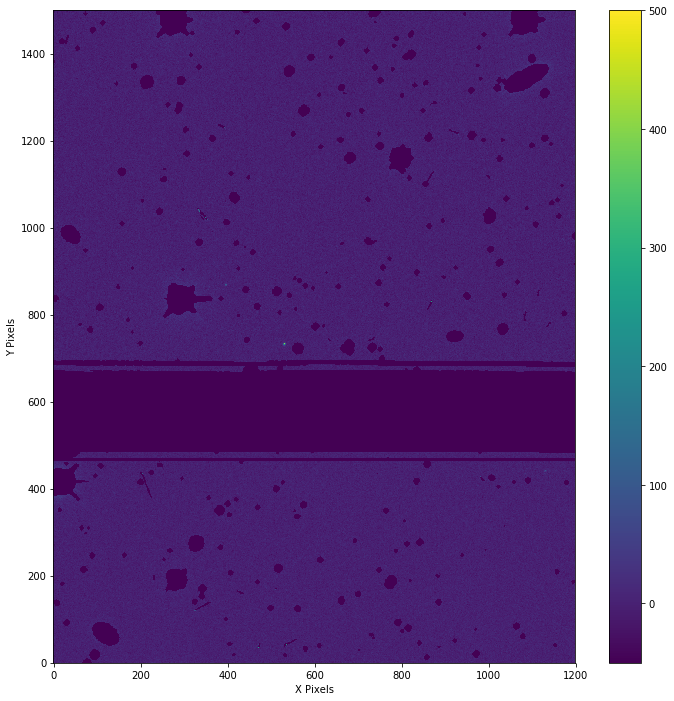

In [180]:
fig = plt.figure(figsize=(12,12))
plt.imshow(sub, origin='lower',  vmin=-50, vmax=500)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [183]:
search = kb.stack_search(stack, p)

In [184]:
search.gpu(50,50, 0.15, 0.9, 2300.0, 3200.0)

In [185]:
#search.filter_min_obs(3)

In [186]:
res = search.get_results(0, 10000)

In [187]:
res = [t for t in res if t.obs_count>2]

In [188]:
#search.save_results("filtered.txt")

In [189]:
len(res)

21

In [52]:
res

[lh: 138.453003 flux: 9873.385742 x: 2255 y: 1275 x_v: 1976.203735 y_v: 2014.522949 obs_count: 3,
 lh: 135.394699 flux: 8691.991211 x: 432 y: 2974 x_v: 2793.225342 y_v: 1148.168945 obs_count: 3,
 lh: 126.149994 flux: 3451.456055 x: 3123 y: 3043 x_v: 2428.268555 y_v: 1040.997559 obs_count: 3,
 lh: 122.266182 flux: 3240.961182 x: 3126 y: 3045 x_v: 2411.724609 y_v: 1033.905273 obs_count: 3,
 lh: 122.152214 flux: 3267.580078 x: 3123 y: 3044 x_v: 2428.268555 y_v: 1040.997559 obs_count: 3,
 lh: 122.138527 flux: 3335.924805 x: 3124 y: 3044 x_v: 2428.268555 y_v: 1040.997559 obs_count: 3,
 lh: 119.428062 flux: 3203.938477 x: 3121 y: 3042 x_v: 2444.812256 y_v: 1048.089966 obs_count: 3,
 lh: 117.922615 flux: 3094.543457 x: 3127 y: 3045 x_v: 2411.724609 y_v: 1033.905273 obs_count: 3,
 lh: 117.387085 flux: 3164.751221 x: 3124 y: 3043 x_v: 2428.268555 y_v: 1040.997559 obs_count: 3,
 lh: 117.085182 flux: 7836.525879 x: 2253 y: 1275 x_v: 1988.808838 y_v: 2027.372559 obs_count: 3,
 lh: 114.757835 flux: